# Exploring Dandiset 001174: Calcium imaging in SMA and M1 of macaques

*Note: This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results.*

## Overview

This notebook explores Dandiset 001174, which contains calcium imaging data recorded from the Supplementary Motor Area (SMA) and Primary Motor Cortex (M1) of rhesus macaques. The data was collected using one-photon calcium imaging with miniature microscopes while the animals were at rest or performing an arm reaching task.

Link to the Dandiset: [https://dandiarchive.org/dandiset/001174/0.250331.2218](https://dandiarchive.org/dandiset/001174/0.250331.2218)

This dataset provides valuable insights into neuronal activity patterns in motor cortices of non-human primates, which is relevant to understanding human motor control in both healthy conditions and movement disorders.

In this notebook, we will:

1. Access and explore the Dandiset metadata
2. Examine the structure of the NWB files contained in the dataset
3. Visualize calcium imaging data and extracted fluorescence signals
4. Explore ROI (Region of Interest) activities and their patterns

## Required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import h5py
import remfile
import pynwb
from dandi.dandiapi import DandiAPIClient
from datetime import datetime

## Accessing the Dandiset metadata

In [2]:
# Initialize a DANDI API client and get the dandiset
client = DandiAPIClient()
dandiset = client.get_dandiset("001174", "0.250331.2218")
metadata = dandiset.get_raw_metadata()

# Display basic information about the dandiset
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Dandiset DOI: {metadata['doi']}")
print(f"Version: {metadata['version']}")
print(f"Date published: {metadata['datePublished']}")

Dandiset name: Calcium imaging in SMA and M1 of macaques
Dandiset URL: https://dandiarchive.org/dandiset/001174/0.250331.2218
Dandiset DOI: 10.48324/dandi.001174/0.250331.2218
Version: 0.250331.2218
Date published: 2025-03-31T22:18:19.390100+00:00


### Exploring the dataset description

In [3]:
print("Description:")
print(metadata['description'])

Description:
The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution. We used this method to examine activity patterns of projection neurons in deep layers of the supplementary motor (SMA) and primary motor areas (M1) in four rhesus macaques. We implanted gradient index lenses and expressed GCaMP6f to image calcium transients while the animals were at rest or engaged in an arm reaching task. We tracked the activity of SMA and M1 neurons across conditions, examined cell pairs for synchronous activity, and assessed whether SMA and M1 neuronal activation followed specific sequential activation patterns. We demonstrate the value of in vivo calcium imaging for studying patterns of activity in groups of corticofugal neurons in SMA and M1.


In [4]:
print("Keywords:")
for keyword in metadata['keywords']:
    print(f"- {keyword}")

Keywords:
- One-photon calcium imaging, non-human primates, microendoscope, reaching task, neuronal coactivation, calcium sensors, GCaMP, GRIN lens


### Dataset contributors

In [5]:
print("Contributors:")
for contributor in metadata['contributor']:
    if contributor.get('includeInCitation', False) and 'name' in contributor:
        print(f"- {contributor['name']}")

Contributors:
- Galvan, Adriana
- Martel, Anne-Caroline
- Pittard, Damien
- Devergnas, Annaelle
- Risk, Benjamin
- Nassi, Jonathan J.
- Yu, Waylin
- Downer, Joshua D. 
- Wichmann, Thomas


### Dataset summary

In [6]:
assets_summary = metadata['assetsSummary']

print(f"Number of files: {assets_summary['numberOfFiles']}")
print(f"Number of subjects: {assets_summary['numberOfSubjects']}")
print(f"Total size: {assets_summary['numberOfBytes'] / (1024**3):.2f} GB")

print("\nSpecies:")
for species in assets_summary['species']:
    print(f"- {species['name']}")

print("\nApproach:")
for approach in assets_summary['approach']:
    print(f"- {approach['name']}")

print("\nMeasurement techniques:")
for technique in assets_summary['measurementTechnique']:
    print(f"- {technique['name']}")

Number of files: 45
Number of subjects: 4
Total size: 640.40 GB

Species:
- Macaca mulatta - Rhesus monkey

Approach:
- microscopy approach; cell population imaging

Measurement techniques:
- analytical technique
- surgical technique
- one-photon microscopy technique


## Exploring files in the Dandiset

In [7]:
# List the files in the Dandiset
assets = list(dandiset.get_assets())
print(f"Total number of assets: {len(assets)}")

# Display the first 10 assets
print("\nSample of files in the Dandiset:")
for i, asset in enumerate(assets[:10]):
    print(f"{i+1}. {asset.path}")

Total number of assets: 45

Sample of files in the Dandiset:
1. sub-V/sub-V_ses-20230309T110929_ophys.nwb
2. sub-Q/sub-Q_ophys.nwb
3. sub-Q/sub-Q_ses-20220922T131747_ophys.nwb
4. sub-Q/sub-Q_ses-20221003T131952_ophys.nwb
5. sub-Q/sub-Q_ses-20221028T121142_ophys.nwb
6. sub-Q/sub-Q_ses-20221201T132256_ophys.nwb
7. sub-Q/sub-Q_ses-20221202T122907_ophys.nwb
8. sub-Q/sub-Q_ses-20221206T121002_ophys.nwb
9. sub-Q/sub-Q_ses-20220915T133954_ophys.nwb
10. sub-Q/sub-Q_ses-20221201T134628_ophys.nwb


Let's group the assets by subject to better understand the dataset structure:

In [8]:
# Group assets by subject
subject_files = {}
for asset in assets:
    # Extract subject ID from the path
    parts = asset.path.split('/')
    if len(parts) > 0:
        subject = parts[0]  # The subject ID (e.g., sub-Q, sub-V)
        if subject not in subject_files:
            subject_files[subject] = []
        subject_files[subject].append(asset.path)

# Print the number of files per subject
for subject, files in subject_files.items():
    print(f"{subject}: {len(files)} files")

sub-V: 4 files
sub-Q: 14 files
sub-F: 9 files
sub-U: 18 files


## Loading and examining an NWB file

Now, let's load one of the NWB files to examine its structure and content. We'll use the file `sub-V/sub-V_ses-20230309T110929_ophys.nwb` as an example.

In [9]:
# Get the download URL for the specific file
file_path = "sub-V/sub-V_ses-20230309T110929_ophys.nwb"
asset = next(dandiset.get_assets_by_glob(file_path))
url = asset.download_url

# Load the NWB file using remfile (stream without downloading)
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

### Examining the NWB file structure and metadata

In [10]:
# Print basic metadata from the NWB file
print(f"Session description: {nwb.session_description}")
print(f"Session identifier: {nwb.identifier}")
print(f"Session start time: {nwb.session_start_time}")
print(f"File creation date: {nwb.file_create_date[0]}")

# Subject information
print("\nSubject information:")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")

Session description: Calcium imaging in M1 during the arm reaching condition
Session identifier: ef45b76c-6097-4571-bfef-7f9cc2e9c3bb
Session start time: 2023-03-09 11:09:29.585000+00:00
File creation date: 2024-11-21 21:30:50.335652+00:00

Subject information:
Subject ID: V
Species: Macaca mulatta
Age: P4Y
Sex: M


### Exploring the device and imaging plane information

In [11]:
# Print information about the imaging device
device_name = list(nwb.devices.keys())[0]  # Get the first device
device = nwb.devices[device_name]

print(f"Device name: {device_name}")
print(f"Description: {device.description}")
print(f"Manufacturer: {device.manufacturer}")

# Print information about the imaging plane
imaging_plane_name = list(nwb.imaging_planes.keys())[0]  # Get the first imaging plane
imaging_plane = nwb.imaging_planes[imaging_plane_name]

print(f"\nImaging plane name: {imaging_plane_name}")
print(f"Description: {imaging_plane.description}")
print(f"Excitation lambda: {imaging_plane.excitation_lambda} nm")
print(f"Imaging rate: {imaging_plane.imaging_rate} Hz")
print(f"Indicator: {imaging_plane.indicator}")
print(f"Location: {imaging_plane.location}")

Device name: Miniscope
Description: NVista3
Manufacturer: Inscopix, Inc.

Imaging plane name: ImagingPlane
Description: The plane being imaged by the miniscope
Excitation lambda: 475.0 nm
Imaging rate: 10.0 Hz
Indicator: N/A
Location: N/A


## Examining the one-photon calcium imaging data

Now let's look at the raw calcium imaging data stored in the `OnePhotonSeries` object:

In [12]:
# Get the OnePhotonSeries data
acquisition = nwb.acquisition
one_photon_series_name = list(acquisition.keys())[0]
one_photon_series = acquisition[one_photon_series_name]

# Print information about the one-photon series
print(f"Name: {one_photon_series_name}")
print(f"Description: {one_photon_series.description}")
print(f"Imaging rate: {one_photon_series.rate} Hz")
print(f"Data shape: {one_photon_series.data.shape}")
print(f"Data type: {one_photon_series.data.dtype}")
print(f"Data unit: {one_photon_series.unit}")

Name: OnePhotonSeries
Description: Miniscope imaging data
Imaging rate: 10.0 Hz
Data shape: (5185, 1280, 800)
Data type: uint16
Data unit: fluorescence


### Visualizing calcium imaging data

Let's visualize a sample frame from the calcium imaging data:

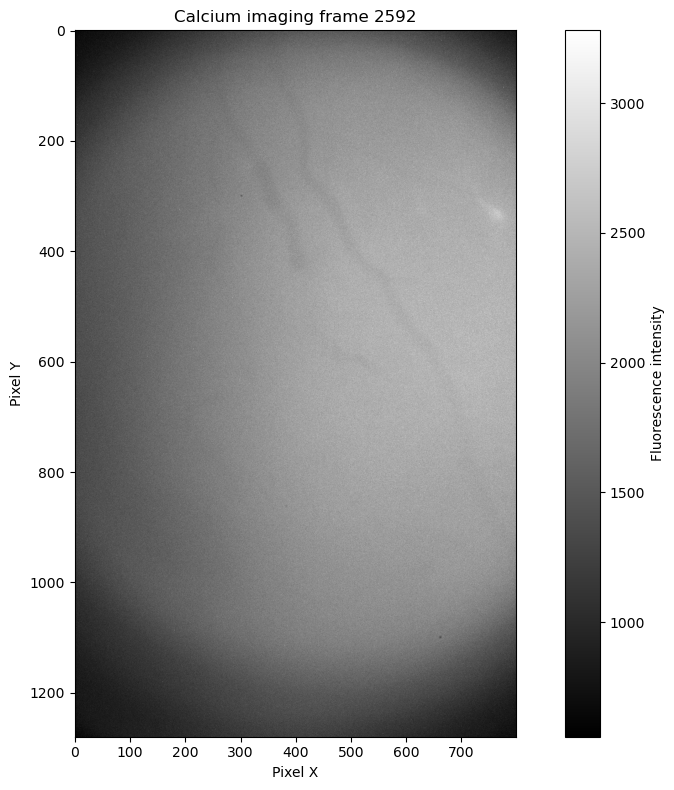

In [13]:
# Get a sample frame from the middle of the recording
frame_index = one_photon_series.data.shape[0] // 2
sample_frame = one_photon_series.data[frame_index]

# Plot the sample frame
plt.figure(figsize=(10, 8))
plt.imshow(sample_frame, cmap='gray')
plt.colorbar(label='Fluorescence intensity')
plt.title(f'Calcium imaging frame {frame_index}')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.tight_layout()
plt.show()

## Exploring ROI segmentation and fluorescence data

Now let's examine the ROIs (regions of interest) that were identified in the calcium imaging data.

In [14]:
# Access the processing module
processing = nwb.processing
processing_module_name = list(processing.keys())[0]  # Get the first processing module
processing_module = processing[processing_module_name]

print(f"Processing module: {processing_module_name}")
print(f"Description: {processing_module.description}")

# Get the data interfaces in the processing module
data_interfaces = processing_module.data_interfaces
print("\nData interfaces:")
for name in data_interfaces.keys():
    print(f"- {name}")

Processing module: ophys
Description: Optical physiology data obtained by processing raw calcium imaging data

Data interfaces:
- EventAmplitude
- Fluorescence
- ImageSegmentation


### Examining ROI segmentation results

In [15]:
# Access the image segmentation data
image_segmentation = data_interfaces['ImageSegmentation']
plane_segmentation_name = list(image_segmentation.plane_segmentations.keys())[0]
plane_segmentation = image_segmentation.plane_segmentations[plane_segmentation_name]

# Get information about the segmentation
print(f"Plane segmentation name: {plane_segmentation_name}")
print(f"Description: {plane_segmentation.description}")
print(f"Number of ROIs: {len(plane_segmentation)}")
print(f"Column names: {plane_segmentation.colnames}")

Plane segmentation name: PlaneSegmentation
Description: Footprints of individual cells obtained by segmenting the field of view
Number of ROIs: 11
Column names: ('image_mask',)


Let's examine the structure of the ROI masks to understand how they are stored:

In [16]:
# Get information about the image masks for the ROIs
num_rois = len(plane_segmentation)
print(f"Number of ROIs: {num_rois}")

# Let's examine the first ROI mask to understand its format
first_mask = plane_segmentation.image_mask[0]
print(f"First ROI mask type: {type(first_mask)}")
print(f"First ROI mask shape: {first_mask.shape}")

# Examine the values in the mask to understand what's stored
mask_values = np.unique(first_mask)
print(f"Unique values in mask: {mask_values}")
print(f"Number of non-zero elements: {np.count_nonzero(first_mask)}")

Number of ROIs: 11
First ROI mask type: <class 'numpy.ndarray'>
First ROI mask shape: (318, 197)
Unique values in mask: [0.         0.01549821 0.01691732 0.01852907 0.01870881 0.0206413
 0.02092103 0.02102549 0.02231812 0.022799   0.0235419  0.02476796
 0.02515844 0.0270659  0.0279171  0.02797559 0.02884467 0.02892807
 0.02896678 0.02944151 0.03143745 0.03147063 0.03179985 0.0318299
 0.03229151 0.03265135 0.03266845 0.03353611 0.03520738 0.03536154
 0.0355514  0.037064   0.03750573 0.03885122 0.03924979 0.03980591
 0.04166169 0.04306225 0.04350769 0.04361197 0.04385701 0.04481704
 0.04596018 0.04601458 0.0473382  0.04856259 0.0498074  0.04981584
 0.051348   0.0521198  0.05502656 0.05631299 0.05752774 0.06048751
 0.0624597  0.06912166 0.07000248 0.07370893 0.07385699 0.07476825
 0.0764335  0.07684088 0.08101326 0.0813786  0.08324571 0.09083361
 0.09502433 0.09587246 0.09959631 0.10206682 0.10413676 0.10476758
 0.10526641 0.10548337 0.10607881 0.10680864 0.11008605 0.11111457
 0.11535285

The ROI masks are stored in a format that doesn't directly correspond to the image dimensions. Instead of trying to reshape them, we'll simply visualize the fluorescence traces from these ROIs.

## Examining fluorescence traces from the ROIs

In [17]:
# Access the fluorescence data
fluorescence = data_interfaces['Fluorescence']
roi_response_series_name = list(fluorescence.roi_response_series.keys())[0]
roi_response_series = fluorescence.roi_response_series[roi_response_series_name]

# Print information about the ROI response series
print(f"ROI response series name: {roi_response_series_name}")
print(f"Description: {roi_response_series.description}")
print(f"Rate: {roi_response_series.rate} Hz")
print(f"Data shape: {roi_response_series.data.shape}")
print(f"Data type: {roi_response_series.data.dtype}")
print(f"Data unit: {roi_response_series.unit}")

ROI response series name: RoiResponseSeries
Description: Fluorescence data associated with spatial footprints
Rate: 10.0 Hz
Data shape: (5185, 11)
Data type: float32
Data unit: fluorescence


Let's visualize the fluorescence traces for the ROIs:

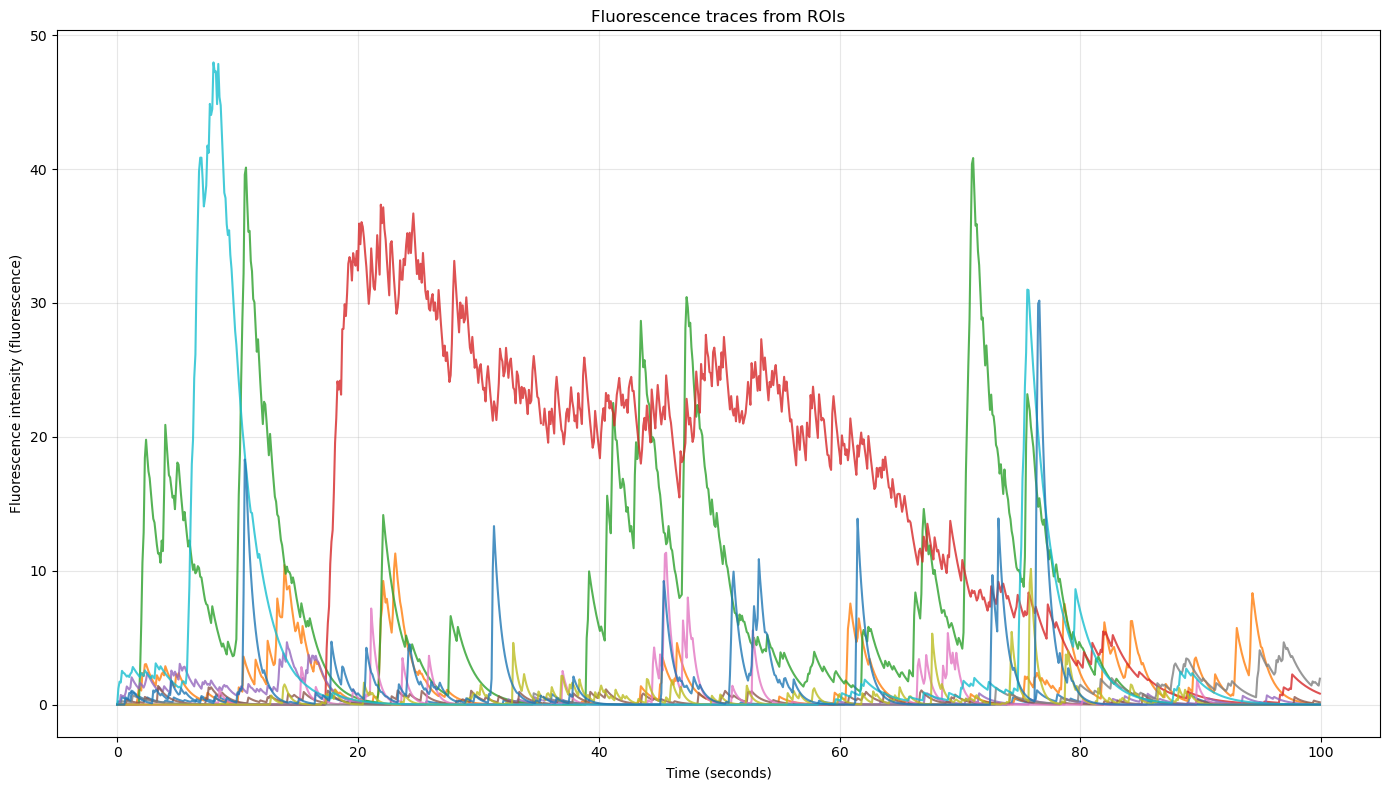

In [18]:
# Plot the fluorescence traces for all ROIs
plt.figure(figsize=(14, 8))

# Number of time points to plot (limit to 1000 points for better visualization)
num_timepoints = min(1000, roi_response_series.data.shape[0])
time_vector = np.arange(num_timepoints) / roi_response_series.rate

# Plot each ROI's fluorescence trace
for i in range(num_rois):
    plt.plot(time_vector, roi_response_series.data[:num_timepoints, i], 
             label=f'ROI {i+1}', alpha=0.8)

plt.xlabel('Time (seconds)')
plt.ylabel(f'Fluorescence intensity ({roi_response_series.unit})')
plt.title('Fluorescence traces from ROIs')
plt.grid(True, alpha=0.3)

# Add a legend if there are not too many ROIs
if num_rois <= 10:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
plt.tight_layout()
plt.show()

## Examining event amplitudes

In addition to the raw fluorescence data, the dataset also contains the amplitudes of detected neural events associated with the ROIs. Let's examine this data:

In [19]:
# Access the event amplitude data
event_amplitude = data_interfaces['EventAmplitude']

# Print information about the event amplitude data
print(f"Description: {event_amplitude.description}")
print(f"Rate: {event_amplitude.rate} Hz")
print(f"Data shape: {event_amplitude.data.shape}")
print(f"Data type: {event_amplitude.data.dtype}")
print(f"Data unit: {event_amplitude.unit}")

Description: Amplitude of neural events associated with spatial footprints
Rate: 10.003749302576672 Hz
Data shape: (5185, 11)
Data type: float64
Data unit: fluorescence


Let's visualize the event amplitudes for some of the ROIs:

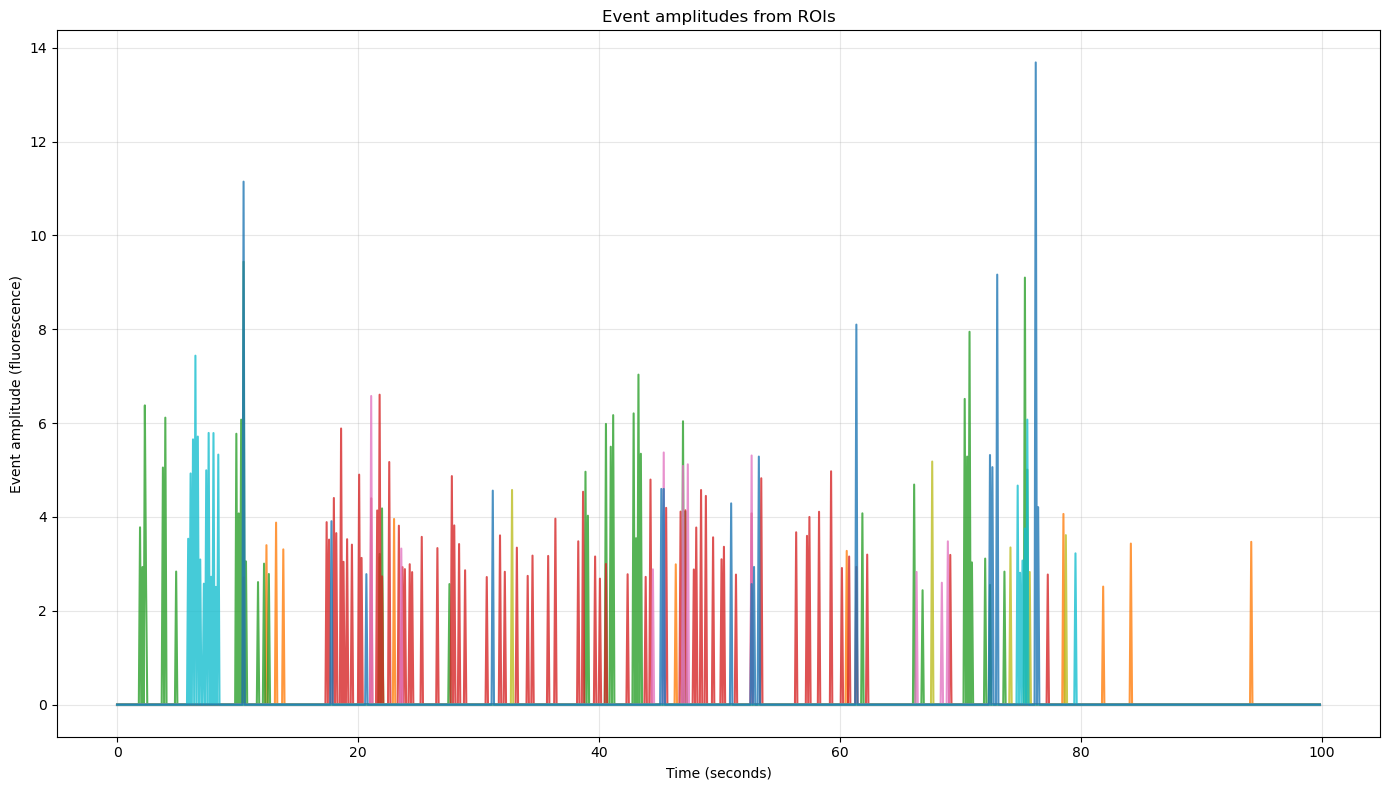

In [20]:
# Plot the event amplitudes for all ROIs
plt.figure(figsize=(14, 8))

# Number of time points to plot (limit to 1000 points for better visualization)
num_timepoints = min(1000, event_amplitude.data.shape[0])
time_vector = np.arange(num_timepoints) / event_amplitude.rate

# Plot each ROI's event amplitude trace
for i in range(num_rois):
    plt.plot(time_vector, event_amplitude.data[:num_timepoints, i], 
             label=f'ROI {i+1}', alpha=0.8)

plt.xlabel('Time (seconds)')
plt.ylabel(f'Event amplitude ({event_amplitude.unit})')
plt.title('Event amplitudes from ROIs')
plt.grid(True, alpha=0.3)

# Add a legend if there are not too many ROIs
if num_rois <= 10:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
plt.tight_layout()
plt.show()

## Comparing fluorescence and event amplitude for a single ROI

To better understand the relationship between the raw fluorescence signal and the detected event amplitudes, let's plot them together for a single ROI:

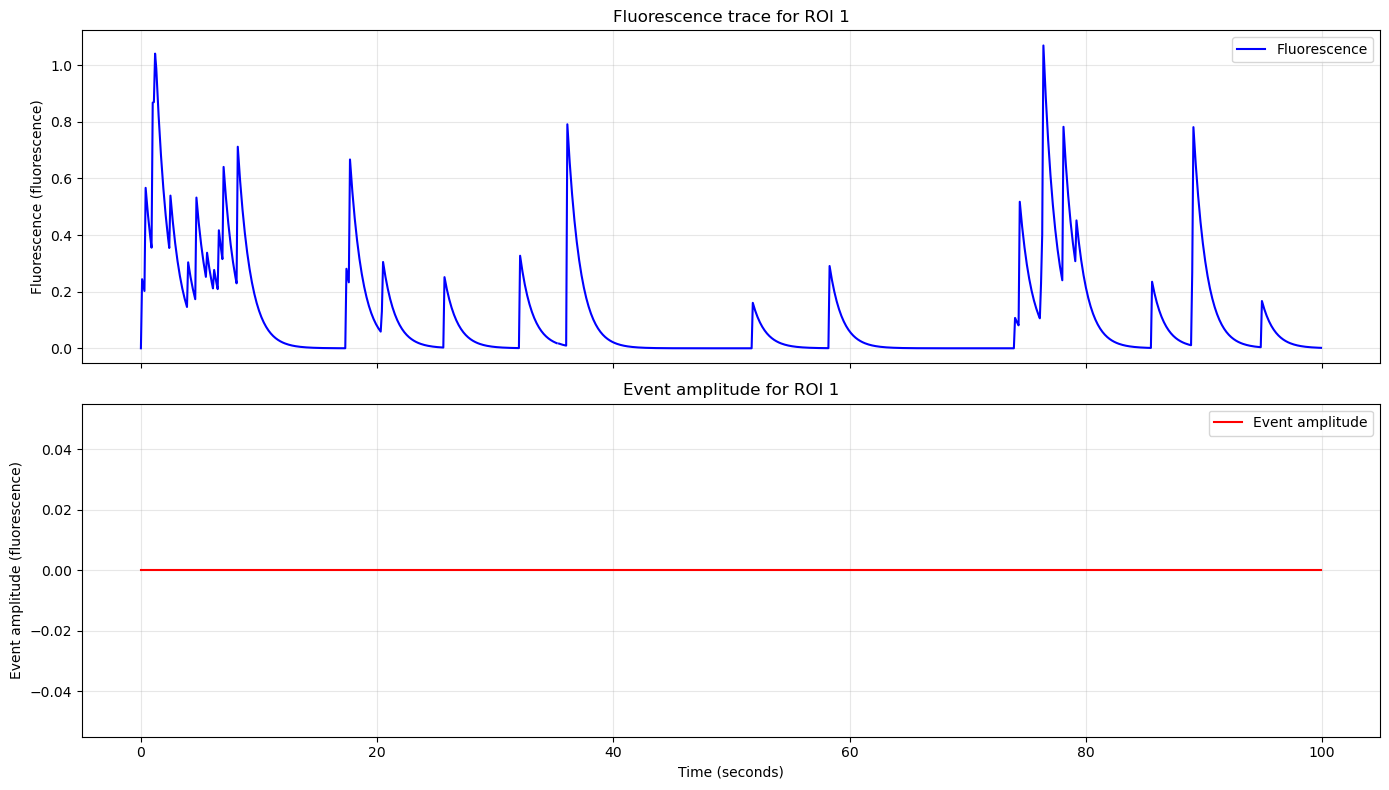

In [21]:
# Select a ROI to visualize (pick one that shows clear activity)
roi_index = 0  # Use the first ROI

# Plot the fluorescence and event amplitude for the selected ROI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Number of time points to plot (limit to 1000 points for better visualization)
num_timepoints = min(1000, roi_response_series.data.shape[0])
time_vector = np.arange(num_timepoints) / roi_response_series.rate

# Plot the fluorescence trace
ax1.plot(time_vector, roi_response_series.data[:num_timepoints, roi_index], 'b-', label='Fluorescence')
ax1.set_ylabel(f'Fluorescence ({roi_response_series.unit})')
ax1.set_title(f'Fluorescence trace for ROI {roi_index+1}')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot the event amplitude trace
ax2.plot(time_vector, event_amplitude.data[:num_timepoints, roi_index], 'r-', label='Event amplitude')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel(f'Event amplitude ({event_amplitude.unit})')
ax2.set_title(f'Event amplitude for ROI {roi_index+1}')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Analyzing correlations between ROIs

Let's examine how the activity of different ROIs correlates with each other:

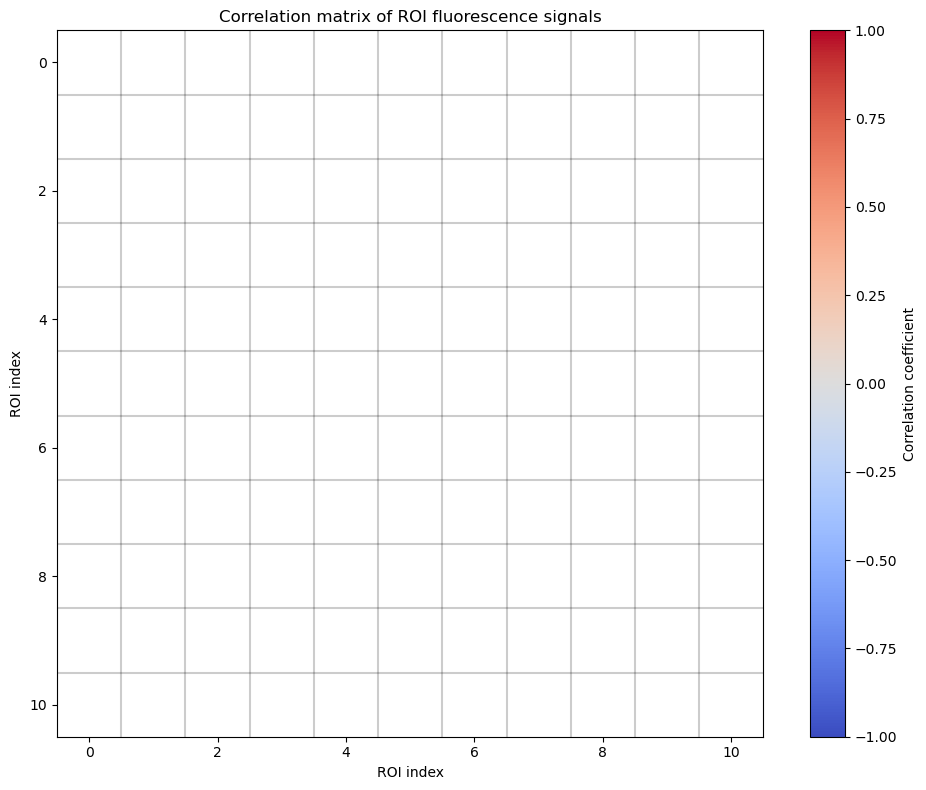

In [22]:
# Calculate the correlation matrix for the fluorescence data
fluorescence_data = roi_response_series.data[:, :]
correlation_matrix = np.corrcoef(fluorescence_data.T)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation matrix of ROI fluorescence signals')
plt.xlabel('ROI index')
plt.ylabel('ROI index')

# Add gridlines
plt.grid(False)

# Add a line for each ROI
for i in range(num_rois):
    plt.axhline(y=i-0.5, color='black', linestyle='-', alpha=0.2)
    plt.axvline(x=i-0.5, color='black', linestyle='-', alpha=0.2)
    
plt.tight_layout()
plt.show()

## Temporal dynamics of ROI activity

Let's create a heatmap to visualize the activity of all ROIs over time:

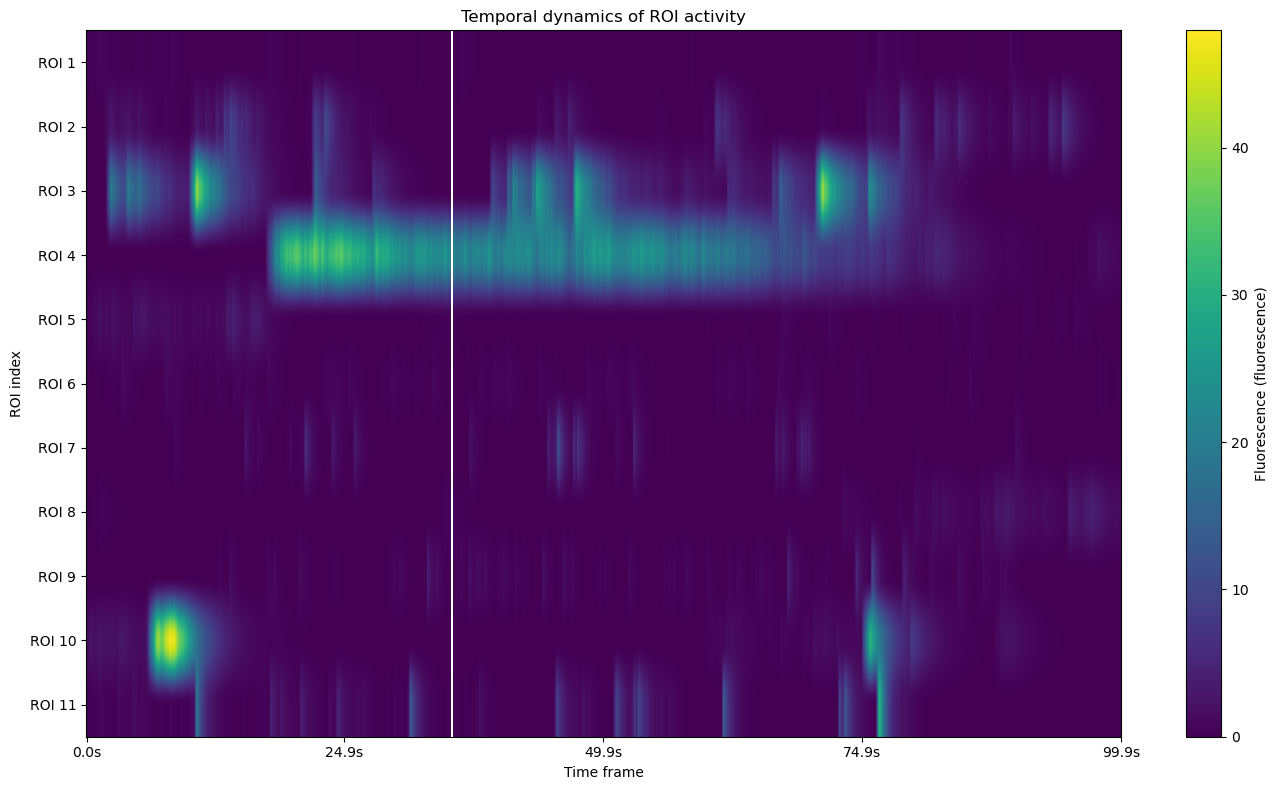

In [23]:
# Create a heatmap of ROI activity over time
plt.figure(figsize=(14, 8))

# Number of time points to plot (limit to 1000 points for better visualization)
num_timepoints = min(1000, roi_response_series.data.shape[0])
roi_data = roi_response_series.data[:num_timepoints, :]

# Create a heatmap
plt.imshow(roi_data.T, aspect='auto', cmap='viridis')
plt.colorbar(label=f'Fluorescence ({roi_response_series.unit})')
plt.title('Temporal dynamics of ROI activity')
plt.xlabel('Time frame')
plt.ylabel('ROI index')

# Add time ticks
time_ticks = np.linspace(0, num_timepoints-1, 5, dtype=int)
time_labels = [f'{t/roi_response_series.rate:.1f}s' for t in time_ticks]
plt.xticks(time_ticks, time_labels)

# Add ROI ticks
roi_ticks = np.arange(num_rois)
plt.yticks(roi_ticks, [f'ROI {i+1}' for i in roi_ticks])

plt.tight_layout()
plt.show()

## Analyzing event detection

Let's identify where events occur in the fluorescence data for a single ROI, to better understand how calcium events are detected in the dataset:

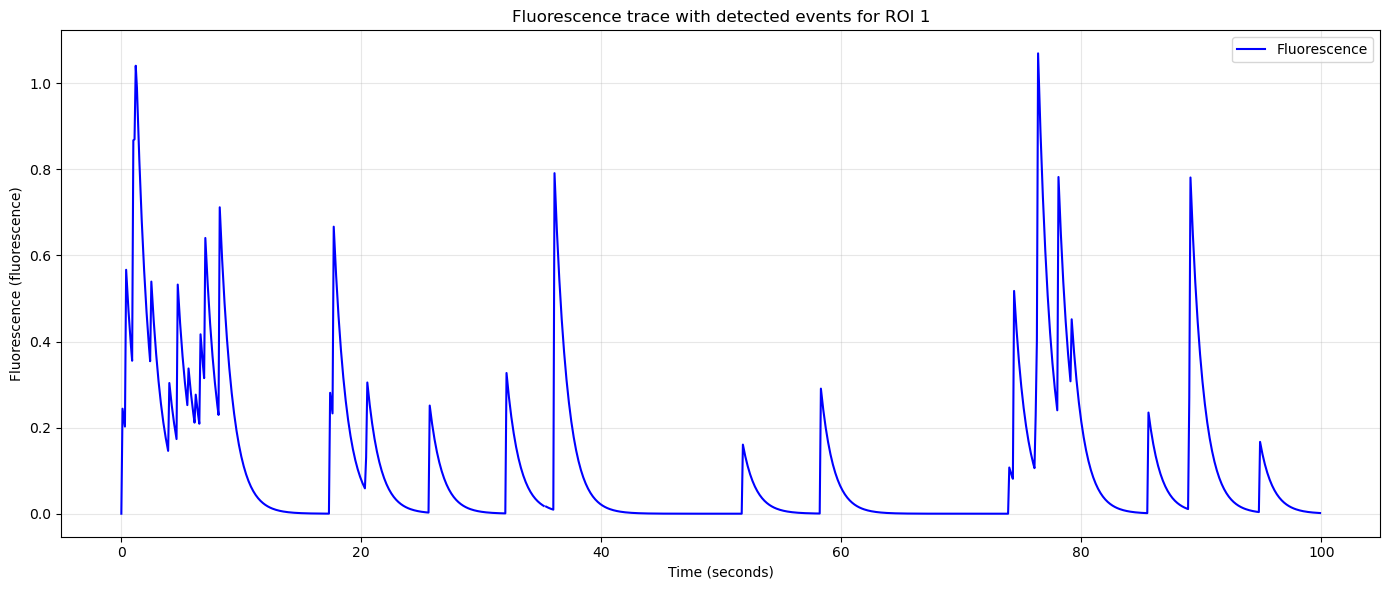

In [24]:
# Select a ROI to analyze
roi_index = 0  # Use the first ROI

# Get the fluorescence trace and event amplitudes for this ROI
fluorescence_trace = roi_response_series.data[:, roi_index]
event_trace = event_amplitude.data[:, roi_index]

# Identify time points with significant events (non-zero event amplitude)
event_threshold = 0.01  # Simple threshold to identify events
event_times = np.where(event_trace > event_threshold)[0]

# Plot the fluorescence trace with event markers
plt.figure(figsize=(14, 6))

# Number of time points to plot (limit to 1000 points for better visualization)
num_timepoints = min(1000, len(fluorescence_trace))
time_vector = np.arange(num_timepoints) / roi_response_series.rate

# Plot the fluorescence trace
plt.plot(time_vector, fluorescence_trace[:num_timepoints], 'b-', label='Fluorescence')

# Mark the events
for event_time in event_times:
    if event_time < num_timepoints:
        plt.axvline(x=event_time/roi_response_series.rate, color='r', alpha=0.3, linestyle='-')

# Add markers for significant events
significant_events = np.where(event_trace > np.percentile(event_trace, 95))[0]
for event_time in significant_events:
    if event_time < num_timepoints:
        plt.plot(event_time/roi_response_series.rate, fluorescence_trace[event_time], 'ro', markersize=8)

plt.xlabel('Time (seconds)')
plt.ylabel(f'Fluorescence ({roi_response_series.unit})')
plt.title(f'Fluorescence trace with detected events for ROI {roi_index+1}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Summary and Future Directions

In this notebook, we explored Dandiset 001174, which contains calcium imaging data from the SMA and M1 regions of macaque monkeys. We've:

1. Accessed and examined the metadata of the dandiset
2. Explored the structure of an example NWB file
3. Visualized calcium imaging data frames
4. Analyzed fluorescence traces and event amplitudes from identified ROIs
5. Investigated correlations between ROIs and their temporal dynamics
6. Visualized how calcium events relate to the fluorescence signals

For future exploration, researchers might consider:
- Comparing activity patterns between rest and reaching tasks
- Analyzing differences in neuronal activity between SMA and M1
- Investigating synchronous activity in cell pairs
- Examining sequential activation patterns across neurons
- Correlating calcium activity with behavioral markers from the arm reaching task